# Part three Docking of the found ligands

## Step 1. Packages & Ligand Editing

### Step 1.1 Installing the neccesary packages
In this part we will focus on docking the promising ligands determined by our Model. We start with importing the nessecary packages.

In [1]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina
#import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import PandasTools

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import nglview
from scripts import viewer

import sys, os, shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
# Note we commented out pymol, openm and pdbfixer.
#from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import os
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# Silence some expected warnings
filterwarnings("ignore")

# Set seed for reproducible results
SEED = 22
seed_everything(SEED)

As in the previous steps we create an enviroment to work in or check if the directory is already present.

In [2]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')

Directory already exists


### 1.2 Importing and deleting double lines in the .pdb files.
Due to the fact that 5F1A has been crystallized as a dimer, the .pdb files `5F1A_prepped.pdb` and `ligand-SAL.pdb` contain the sequence for two proteins.
This gives an issues when trying to calculate the docking box. Therefore we created the function below to clean-up the .pdb files and subsequently make then suitable for docking.

In [3]:
def remove_lines(file_name, start_line, end_line):
    
    with open(file_name, 'r') as file:
        lines = file.readlines()

    del lines[start_line-1:end_line]

    with open(file_name, 'w') as file:
        file.writelines(lines)

    print(f"Lines {start_line} to {end_line} deleted successfully and changes saved to {file_name}.")

In [4]:
PDBCODE = '5F1A' # Protein data bank code: 51FA = human COX2
LIGAND_CODE = 'SAL' # Subsequent addition of ligad, SAL = salic. acid (cocrystallized ligand of 5F1A)
shutil.copy('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE), '{}_prepped.pdb'.format(PDBCODE))
shutil.copy('../Bioinformatics/ligand-{}.pdb'.format(LIGAND_CODE), 'ligand-{}.pdb'.format(LIGAND_CODE))

remove_lines('5F1A_prepped.pdb', 8748, 17450) # should be around 469.8 KB after removing
remove_lines('ligand-SAL.pdb', 12, 22) # should be around 899 B after removing

Lines 8748 to 17450 deleted successfully and changes saved to 5F1A_prepped.pdb.
Lines 12 to 22 deleted successfully and changes saved to ligand-SAL.pdb.


## 2. System & Ligand Visualization

We will visualize the system once more and take a look at the structure and the ligands

In [5]:
test_smiles = [
                      
    'OC1=CC=CC=C1C(O)=O', # Salicylic acid (SAL)
    'O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl', #aclofenac
    'O=C(O)C1=CC=NC=C1OC', # sal alt, pyridine en methoxy pose 4
    'OC1=CC=C2C(C=CC2)=C1C(O)=O', # sal alt extra ring pose 0
    'C1=CC=C(C(=C1)C(=O)O)C(=O)O', # phtalic acid
    'NC1=CC=CC=C1C(O)=O', # sal alt met N ipv O (aminobenzeenzuur)
    'OC1=CC=CC=C1C(N)=O', # sal alt met C(N)=O ip C(O)=O (hydroxybenzeenamide)
    'Cc2onc(c1ccccc1)c2c3ccc(S(N)(=O)=O)cc3', # VALDECOXIB
    'CCC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3', # VALDECOXIB met extra N en methylgroep
    'CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3', # VALDECOXIB met extra N
    'NS(=O)(=O)c3ccc(C1=C(CN=O)ONC1c2ccccc2)cc3', # VALDECOXIB met extra ethyl plus N en O
    'NS(=O)c2c(O)ccc1CC=Cc12', # sal met extra ring en een S op de zuur groep
    'NC(=O)c1c(O)ccc2occc12', # sal met extra ring en een stikstof op een n groep
    'Nc2ccc1CC=Cc1c2C(=O)', # sal met extra ring, een N op een O groep en de zuur groep vervangen door een O
    'OC1=CC=C2C(C=CC2)=C1C(O)=N', # sal alt met carbimidic acid en extra ring (pose 2) 
    'OC1=CC(C)=C(F)C=C1C(O)=O', # sal alt met fluoride, methyl (pose2)
    'OC1=CC(F)=C(F)C=C1C(O)=O', # sal alt met di fluoride (pose 0)
    'COc1ccc2cc(CCC(C)=O)ccc2c1', # NABUMETONE
]

The 3D files will be generated using rdkit. It will automatically number, so they will be called ligand_00, ligand_01, etc.

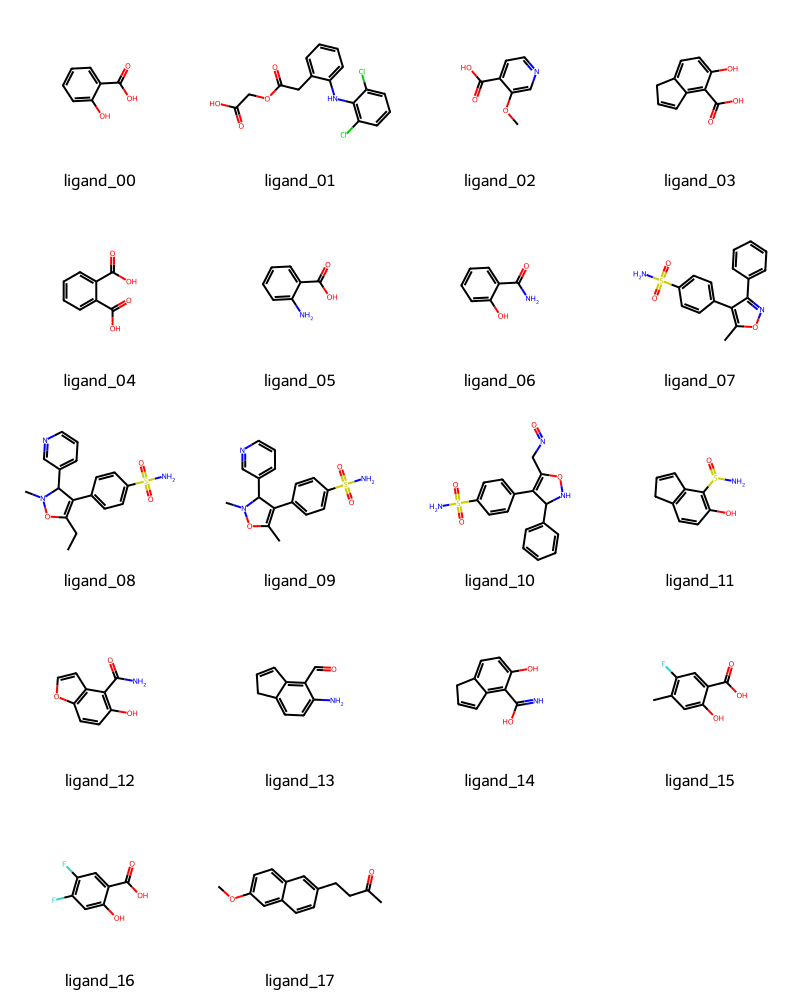

In [6]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img

The code above has generated 2d images of the tested ligands. It also added the hydrogens to these ligands and saved them as mol2 files, so that we can use them for the next docking steps. Note the automatic numbering of the ligands as previously mentioned.

In [7]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand_00.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Of note is the green molecule. This is Ligand_00 and was generated from scratch. Therefore it is missing coordinates and is placed far away from the the binding site. The salicylic acid molecule that was co-crystalised with COX2 is shown in magenta and is located in the binding site. We have confirmed that the correct ligand is present in the binding site and now we will try to redock the ligand in the protein binding site.

## 3. Docking with AutoDock Vina

### 3.1. Protein and ligand preparation

Ligand have been cleand up and  the docking site has been checked with a ligand. To proceed the ligands will be converted to the PDBQT file format. This file format stores the atomic coordinates, partial charges and AutoDock atom types. It does this for both the receptor, the ligand and all newly created ligands. 

In [15]:
from math import isnan, isinf

def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

### 3.2. Box definition

It has been shown that using the radius of gyration, we can generate an efficient box for the docking process:
FROM: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0067-5
We will calculate the radius of gyration, as well as the center of geometry of the ligand to define the box size.

In [16]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

Radius of Gyration = 2.02


In [17]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Center Of Geometry = [42.043, 23.986, 240.114]


### 3.4. Docking

AutoDock Vina was used to dock the promising ligands in the binding site and predict the affinity and pCHEMBL value. Vina will perform multiple docking simulations and score the binding poses based on an empirically derived scoring function which takes into account the interactions between the atoms of the ligand and receptor binding site. It will rank the docking poses based on predicted binding affinity as expressed in free energy chain upon binidng (kcal/mol), which it will translate to a predicted pCHEMBL value.

In [21]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [22]:
# From this code block, all code block belows need to be ran seperately for each ligand. 
# You change the name of the ligand, so ligand_00 (reference ligand), ligand_01, ligand_02, etc.
LIGAND_TO_DOCK = 'ligand_06' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

In [25]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses(f'docking_results_{LIGAND_TO_DOCK}.pdbqt', n_poses=10, overwrite=True)

with open(f"docking_results_{LIGAND_TO_DOCK}.pdbqt") as infile:
    saving = False
    molecule = []
    i = 0
    for line in infile:
        if not saving:
            if line.startswith("MODEL"):
                saving = True
        elif line.startswith("ENDMDL"):
            saving = False
            fp = open(f"docking_results_{LIGAND_TO_DOCK}_pose{i}.pdbqt", "w")
            fp.writelines(molecule)
            fp.close()
            i += 1
            molecule = []
        else:
            molecule.append(line)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -5.662          0          0
   2       -5.641      3.008      4.254
   3       -5.449      2.115      2.812
   4       -5.444      2.722      3.605
   5       -5.391      2.537      3.699
   6       -5.382      2.516      3.534
   7        4.468      2.064      2.501
   8        8.249       2.88      3.959
   9        8.707      2.565      3.618
  10        312.8      2.434      3.669
Computing Vina grid ... done.
Performing docking (random seed: 1464546693) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [27]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock(f'docking_results_{LIGAND_TO_DOCK}_pose0.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -5.659 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 4.15


### 3.5. 3D visualization of docking results

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if exist). The ligand's "Pose" and "Score" information will also be displayed to show how acces to this molecule's attributes.

In [28]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [29]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

## Results
As noted before, new ligands were tested using the Machine Learning Model. Certain ligands with predicited pCHEMBL values worse than the reference ligand were tested to study what groups are essential for a better binding to the binding pocket. After the Machine Learning Model, the ligand was tested using AutoDock Vina to determine the binding of this new ligand and how it scored relative to salysilic acid. Besides docking, AutoDock Vina also prediced an affinity value and a pCHEMBL value. Predicted values by AutoDock Vina and the ML model are presented in table 1. for each ligand. Some ligands were unable to be docked by Vina AutoDock, the values for these ligands are noted as N.A.

Table 1. Found values for the tested ligands. Using both Machine Learning (ML) and Vina Docking (Vina)


,Ligand Code,Description,SMILES,Structure Formula,Vina Affinity (kcal/mol),Vina pCHEMBL,ML pCHEMBL,Molecule
0,ligand_00,salicylic acid (reference ligand),OC1=CC=CC=C1C(O)=O,C7H6O4,-5.755,4.22,4.92,
1,ligand_01,aclofenac,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,C16H11Cl2NO5,N.A.,N.A.,6.49,
2,ligand_02,"sal alt, pyridine en methoxy pose 4",O=C(O)C1=CC=NC=C1OC,C7H5NO4,-4.656,3.42,5.56,
3,ligand_02,sal alt extra ring pose 0,OC1=CC=C2C(C=CC2)=C1C(O)=O,C9H6O4,-5.81,4.26,5.47,
4,ligand_04,phtalic acid,C1=CC=C(C(=C1)C(=O)O)C(=O)O,C8H6O4,-5.313,3.9,4.93,
5,ligand_05,sal alt met N ipv O (aminobenzeenzuur),NC1=CC=CC=C1C(O)=O,C7H7NO2,-5.476,4.02,5.06,
6,ligand_06,sal alt met C(N)=O ip C(O)=O (hydroxybenzeenam...,OC1=CC=CC=C1C(N)=O,C8H7NO2,-5.646,4.14,5.05,
7,ligand_07,VALDECOXIB,Cc2onc(c1ccccc1)c2c3ccc(S(N)(=O)=O)cc3,C15H11N3O4S,-inf,2922672.363,7.82,
8,ligand_08,VALDECOXIB met extra N en methylgroep,CCC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3,C19H21N3O4S,N.A.,N.A.,7.05,
9,ligand_09,VALDECOXIB met extra N,CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3,C18H19N3O4S,N.A.,N.A.,7.17,

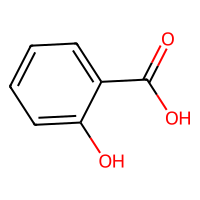
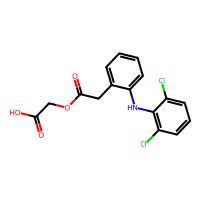
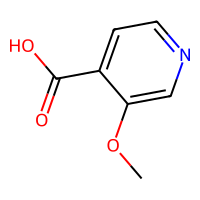
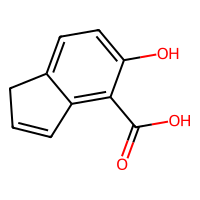
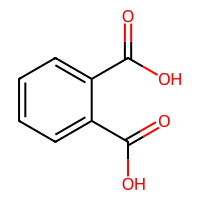
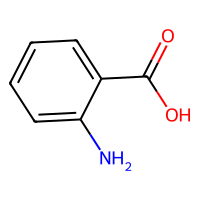
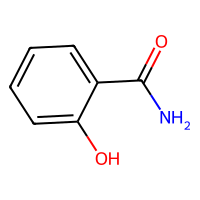
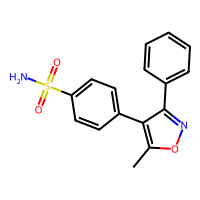
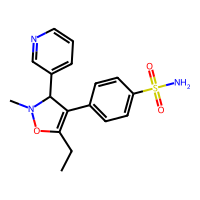
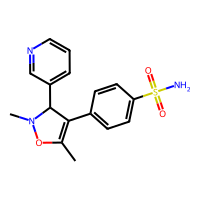
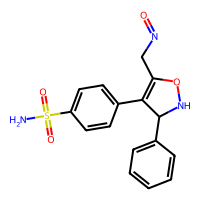
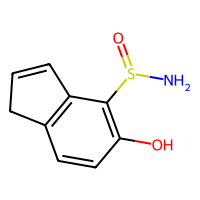
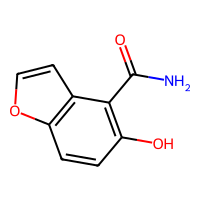
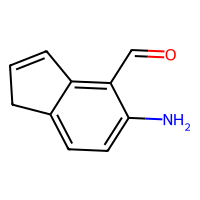
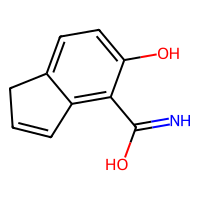
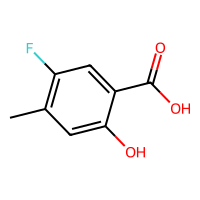
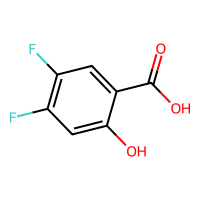
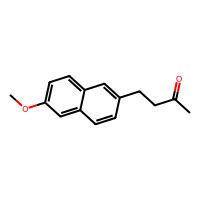

In [35]:
# Convert SMILES to RDKit molecules
molecules = [Chem.MolFromSmiles(smiles) for smiles in test_smiles]

data = {
    'Ligand Code': ['ligand_00', 'ligand_01', 'ligand_02','ligand_02','ligand_04', 'ligand_05', 'ligand_06', 'ligand_07', 'ligand_08', 'ligand_09', 'ligand_10', 'ligand_11', 'ligand_12', 'ligand_13', 'ligand_14', 'ligand_15', 'ligand_16', 'ligand_17'],
    'Description': ['salicylic acid (reference ligand)', 'aclofenac', 'sal alt, pyridine en methoxy pose 4', 'sal alt extra ring pose 0', 'phtalic acid', 'sal alt met N ipv O (aminobenzeenzuur)', 'sal alt met C(N)=O ip C(O)=O (hydroxybenzeenamide)', 'VALDECOXIB', 'VALDECOXIB met extra N en methylgroep', 'VALDECOXIB met extra N', 'VALDECOXIB met extra ethyl plus N en O', 'sal met extra ring en een S op de zuur groep', 'sal met extra ring en een stikstof op een N groep', 'sal met extra ring, een N op een O groep en de zuur groep vervangen door een O', 'sal alt met carbimidic acid en extra ring (pose 2)', 'sal alt met fluoride, methyl (pose2)', 'sal alt met di fluoride (pose 0)', 'NABUMETONE'],
    'SMILES': ['OC1=CC=CC=C1C(O)=O', 'O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl', 'O=C(O)C1=CC=NC=C1OC', 'OC1=CC=C2C(C=CC2)=C1C(O)=O', 'C1=CC=C(C(=C1)C(=O)O)C(=O)O', 'NC1=CC=CC=C1C(O)=O', 'OC1=CC=CC=C1C(N)=O', 'Cc2onc(c1ccccc1)c2c3ccc(S(N)(=O)=O)cc3', 'CCC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3', 'CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3', 'NS(=O)(=O)c3ccc(C1=C(CN=O)ONC1c2ccccc2)cc3', 'NS(=O)c2c(O)ccc1CC=Cc12', 'NC(=O)c1c(O)ccc2occc12', 'Nc2ccc1CC=Cc1c2C(=O)', 'OC1=CC=C2C(C=CC2)=C1C(O)=N', 'OC1=CC(C)=C(F)C=C1C(O)=O', 'OC1=CC(F)=C(F)C=C1C(O)=O', 'COc1ccc2cc(CCC(C)=O)ccc2c1'],
    'Structure Formula': ['C7H6O4', 'C16H11Cl2NO5', 'C7H5NO4', 'C9H6O4', 'C8H6O4', 'C7H7NO2', 'C8H7NO2', 'C15H11N3O4S', 'C19H21N3O4S', 'C18H19N3O4S', 'C15H11N3O5S', 'C10H9NO2S', 'C10H7NO3', 'C10H9NO', 'C8H5NO3', 'C8H7FO3', 'C7H4F2O3', 'C16H16O2'],
    'Vina Affinity (kcal/mol)': [-5.755, 'N.A.', -4.656, -5.81, -5.313, -5.476, -5.646, '-inf', 'N.A.', 'N.A.', 'N.A.', -5.466, -5.315, -5.781, -5.252, -4.536, -5.198, 'N.A.'],
    'Vina pCHEMBL': [4.22, 'N.A.', 3.42, 4.26, 3.90, 4.02, 4.14, 2922672.363, 'N.A.', 'N.A.', 'N.A.', 4, 3.9, 4.24, 3.85, 3.33, 3.81, 'N.A.'],
    'ML pCHEMBL': [4.92, 6.49, 5.56, 5.47, 4.93, 5.06, 5.05, 7.82, 7.05, 7.17, 6.62, 5.49, 4.82, 5.59, 5.16, 5.26, 5.22, 5.29]
}         

#for key, value in data.items():
#    print(f"{key}: {len(value)}")
# Create a DataFrame 
df = pd.DataFrame(data)

# Add a column for the RDKit molecule
PandasTools.AddMoleculeColumnToFrame(df, 'SMILES', 'Molecule')


# Display the DataFrame
print("Table 1. Found values for the tested ligands. Using both Machine Learning (ML) and Vina Docking (Vina)")
df



### Interpretation of the Docking Results

The reference ligand, salicylic acid (ligand_00 in table 1.) was tested by the model and provided the baseline for that molecule. This scaffold was then attemped to be improved by adding or removing certain groups or by changing the scaffold itself. This was done in steps to better study the importance of one group over another. Many of the improvements showed a decrease in both affinity and resultingly a decrease in predicted pCHEMBL value. The ligands that showed a marginal improvement over the reference ligand are ligands two and thirteen, which both have an extra ring structure with a double bond added to them. The location of this ring is different between the two, as well as the functional groups. Where ligand two has a hydroxyl and carboxyl group, in ligand three this has been replaced by a carbonyl group bonded to a methyl and an amino group. The differences between these two new ligands and the reference ligand are very slim, only a difference of 0.03 on average. A possible explanation could be that the carbon atom of this extra ring will form extra hydrophobic interactions, like the other interactions displayed by salicylic acid in the experimental crystal structure. We can shed more light upon the predicted binding poses by looking at the specific binding site interactions. This interaction-specific analysis based on interaction fingerprints (IFPs) will be featured in the "Docking with Alphafold" notebook. 

Another ligand with a different structure was VALDECOXIB (ligands 7 through 10), this is a COX-2 inhibitor synthesised by the industry. This ligand is quite optimized which resulted in great Machine Learning (ML) pCHEMBL values, but also in no improvement in pCHEMBL score with every change made. Furthermore, docking of this ligand was difficult in AutoDock Vina as it would often result in no possible docking and no Vina affinity nor Vina pCEMBL value. When VALDECOXIB was succesfully docked, this resulted in an affinity score of negative infinty and an in comparison astronomical pCHEMBL value. We will try to use a different COX-2 protein model to perform docking on these larger, non SAL-like ligands in the next notebook.

## Comparing Docking and ML affinity predictions
Finally in the next cell, a figure is generated to show the relationship of the pChEMBL predictions for tested compounds between the Machine Learning Regression method and a docking model using VINA. This illustrates the large difference and unreliability of these models. For better models, a larger dataset could be used for training and model testing, a more representative and less-biased target model could be used, or the methods could be improved themselves. 

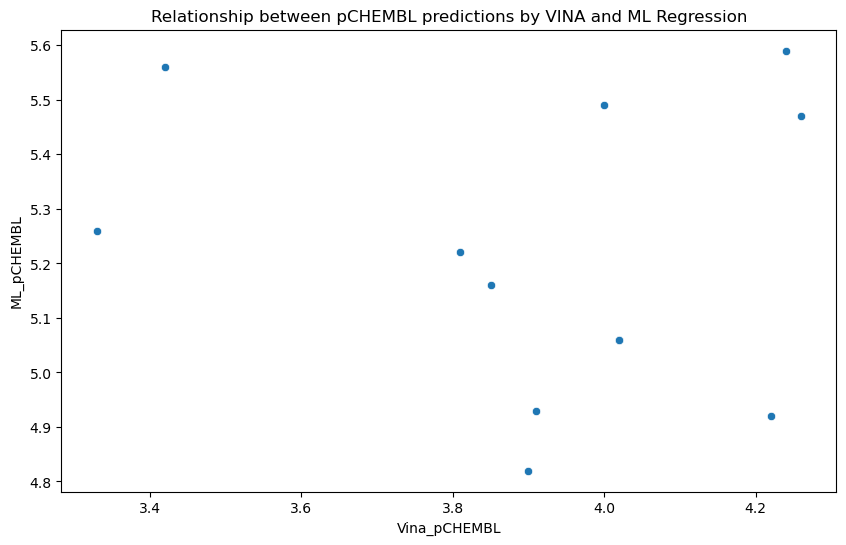

Correlation Coefficient: -0.08844057468600999


In [168]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Vina_pCHEMBL', y='ML_pCHEMBL', data=sallikes)

# Add title and labels
plt.title('Relationship between pCHEMBL predictions by VINA and ML Regression')
plt.xlabel('Vina_pCHEMBL')
plt.ylabel('ML_pCHEMBL')

# Show the plot
plt.show()

# Calculate and display correlation coefficient
correlation = sallikes['Vina_pCHEMBL'].corr(sallikes['ML_pCHEMBL'])
print(f"Correlation Coefficient: {correlation}")